In [1]:
from pyspark.sql import SparkSession

# Spark session & context
spark = (SparkSession
         .builder
         .master('local')
         .appName('wiki-changes-dataviz')
         .config("spark.sql.streaming.schemaInference", True) #Stream dataframe infers schema
         .getOrCreate())
sc = spark.sparkContext

In [2]:
# Read parquet stream
df_stream = (
    spark
    .readStream
    .format("parquet")
    .load("/home/jovyan/work/data-lake/wiki-changes")
)

In [3]:
# Create dataframe grouping by window 
from pyspark.sql.functions import window, col, current_timestamp

df_count = (
    df_stream
    .withWatermark("change_timestamp", "10 minutes") # Don't aggregate events arriving more than 10 minutes late
    .groupBy(
        window(col("change_timestamp"), "10 minutes", "10 minutes"), # 10 minute window, updating every 10 minutes
        col("user"))
    .count()
)

In [4]:
# Create query stream with memory sink
queryStream = (df_count
 .writeStream
 .format("memory")
 .queryName("wiki_changes")
 .outputMode("update")
 .start())

**********************
General Info
**********************
Run:9
Stream timestamp:2020-10-11T13:03:18.452Z
Watermark:2020-10-11T08:33:24.000Z
Total Rows:160
Updated Rows:0
Memory used MB:0.128903
**********************
Graph - Top 10 users
**********************


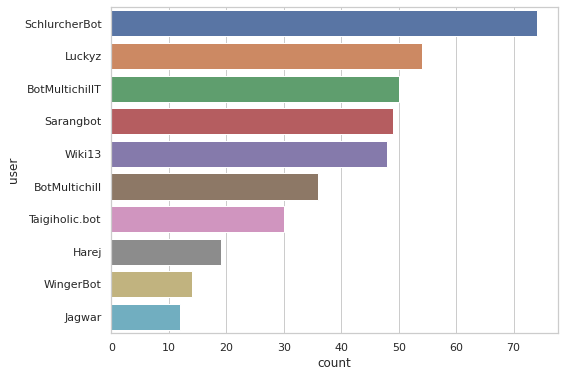

**********************
Table - Top 10 users
**********************


,start,end,user,count
0,2020-10-11 08:40:00,2020-10-11 08:50:00,SchlurcherBot,74
1,2020-10-11 08:40:00,2020-10-11 08:50:00,Luckyz,54
2,2020-10-11 08:40:00,2020-10-11 08:50:00,BotMultichillT,50
3,2020-10-11 08:40:00,2020-10-11 08:50:00,Sarangbot,49
4,2020-10-11 08:40:00,2020-10-11 08:50:00,Wiki13,48
5,2020-10-11 08:40:00,2020-10-11 08:50:00,BotMultichill,36
6,2020-10-11 08:40:00,2020-10-11 08:50:00,Taigiholic.bot,30
7,2020-10-11 08:40:00,2020-10-11 08:50:00,Harej,19
8,2020-10-11 08:40:00,2020-10-11 08:50:00,WingerBot,14
9,2020-10-11 08:40:00,2020-10-11 08:50:00,Jagwar,12


**********************
Table - Count by aggregation window
**********************


,start,end,qty_lines,qty_users
0,2020-10-11 08:40:00,2020-10-11 08:50:00,688,160


process interrupted.


In [5]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
            print("Watermark:{}".format(queryStream.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsUpdated"]))
            print("Memory used MB:{}".format((queryStream.lastProgress["stateOperators"][0]["memoryUsedBytes"]) * 0.000001))
            
        df = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,user
                        ,sum(count) count
                    from
                        wiki_changes
                    where
                        window.start = (select max(window.start) from wiki_changes)
                    group by
                        window.start
                        ,window.end
                        ,user
                    order by
                        4 desc
                    limit 10
                """
        ).toPandas()

        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        print("**********************")
        print("Graph - Top 10 users")
        print("**********************")
        try:
            # Barplot
            sns.barplot(x="count", y="user", data=df)

            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        print("**********************")
        print("Table - Top 10 users")
        print("**********************")
        display(df)
        
        print("**********************")
        print("Table - Count by aggregation window")
        print("**********************")
        df1 = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,sum(count) qty_lines
                        ,count(distinct user) qty_users
                    from
                        wiki_changes
                    group by
                        window.start
                        ,window.end
                    order by
                        window.start desc
                """
        ).toPandas()
        
        display(df1)
        
        sleep(10)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")

In [6]:
# Check active streams
for s in spark.streams.active:
    print("ID:{} | NAME:{}".format(s.id, s.name))

ID:1b6e0f7b-8caf-4223-8411-d6f5cd367f31 | NAME:wiki_changes


In [7]:
# Stop stream
queryStream.stop()